Running simulations for K = 0 folds...


Iterations for K=0: 100%|██████████| 200/200 [00:07<00:00, 25.33it/s]


Running simulations for K = 2 folds...


Iterations for K=2:  50%|█████     | 100/200 [00:26<00:29,  3.39it/s]/Users/ilmun/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Iterations for K=2: 100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


Running simulations for K = 5 folds...


Iterations for K=5: 100%|██████████| 200/200 [04:30<00:00,  1.35s/it]


Running simulations for K = 10 folds...


Iterations for K=10: 100%|██████████| 200/200 [10:02<00:00,  3.01s/it]


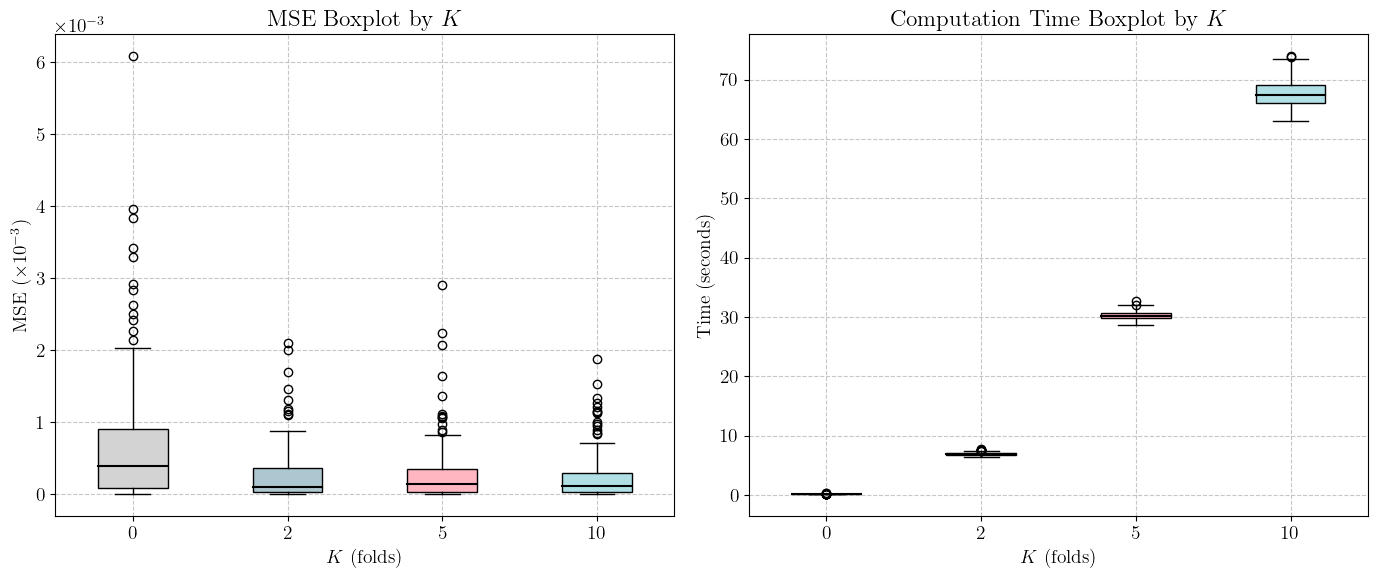

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import KFold
import time
import os

# ----- Helper functions -----

def gini_mean_difference(data):
    n = len(data)
    if n < 2:
        return 0 
    mean_diff = np.abs(np.subtract.outer(data, data)).sum()
    return mean_diff / (n * (n - 1))

def l1(y, data):
    return np.mean(np.abs(y - data))

def generate_data(mean, cov, n, m):
    data = np.random.multivariate_normal(mean, cov, n)
    Y, X = data[:, 0], data[:, 1:]
    data_unlabel = np.random.multivariate_normal(mean, cov, m)
    X_unlabel = data_unlabel[:, 1:]
    return X, Y, X_unlabel

def calculate_Uss(Y, f_label, f_unlabel, Ustat):
    Ustat_ss = Ustat - np.mean(f_label) + np.mean(f_unlabel)
    return Ustat_ss

def fit_and_predict(X, Y, X_unlabel, K=2):
    kf_X = KFold(n_splits=K, shuffle=True, random_state=42)
    kf_X_unlabel = KFold(n_splits=K, shuffle=True, random_state=42)

    f_label, f_unlabel = [], []

    X_folds = [(train, test) for train, test in kf_X.split(X)]
    X_unlabel_folds = [(train, test) for train, test in kf_X_unlabel.split(X_unlabel)]

    for (train_index, test_index), (train_index_unlabel, test_index_unlabel) in zip(X_folds, X_unlabel_folds):
        X1, X2 = X[train_index], X[test_index]
        Y1, Y2 = Y[train_index], Y[test_index]

        X1_unlabel, X2_unlabel = X_unlabel[train_index_unlabel], X_unlabel[test_index_unlabel]

        ell1_Y1 = np.array([l1(y, Y1) for y in Y1])

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X1, ell1_Y1)

        f_label.extend(model.predict(X2))
        f_unlabel.extend(model.predict(X2_unlabel))

    return f_label, f_unlabel

# ----- Simulation settings -----
n = 1000
m = 50000
d = 1001
num_iterations = 1000
rho = 0.90
true = 2 / np.sqrt(np.pi)

mean = np.zeros(d)
cov = np.full((d, d), rho)
np.fill_diagonal(cov, 1)

K_values = [0, 2, 5, 10]

mse_rf_dict = {K: [] for K in K_values}
time_dict = {K: [] for K in K_values}

# ----- Parallelized Simulation over num_iterations -----
def run_single_iteration(K):
    start_time = time.time()
    X, Y, X_unlabel = generate_data(mean, cov, n, m)
    gini_mean_diff = gini_mean_difference(Y)

    if K == 0:
        result_rf = gini_mean_diff
    else:
        f_label, f_unlabel = fit_and_predict(X, Y, X_unlabel, K=K)
        result_rf = calculate_Uss(Y, f_label, f_unlabel, gini_mean_diff)

    mse_rf = np.abs(result_rf - true) ** 2
    end_time = time.time()

    return mse_rf, end_time - start_time

for K in K_values:
    print(f"Running simulations for K = {K} folds...")
    results = Parallel(n_jobs=-1)(delayed(run_single_iteration)(K) for _ in tqdm(range(num_iterations), desc=f"Iterations for K={K}"))
    mse_rf_dict[K] = [result[0] for result in results]
    time_dict[K] = [result[1] for result in results]

plt.rcParams.update({"text.usetex": True, "font.family": "serif", 'font.size': 14})
pastel_colors = ['#D3D3D3', '#AEC6CF', '#FFB6C1', '#B0E0E6']  # Pastel tone colors, added gray for K=0

# ----- Compute Relative MSE -----
mse_mean_0 = np.mean(mse_rf_dict[0])
relative_mse_dict = {K: np.mean(mse_rf_dict[K]) / mse_mean_0 for K in [2, 5, 10]}

# ----- Plot MSE boxplot -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

bp1 = axs[0].boxplot([mse_rf_dict[K] for K in K_values], patch_artist=True, labels=[str(K) for K in K_values])
for patch, color in zip(bp1['boxes'], pastel_colors):
    patch.set_facecolor(color)
for median in bp1['medians']:
    median.set(color='black', linewidth=1.5)

axs[0].set_title(r'Squared Error Boxplot by $k$')
axs[0].set_xlabel(r'$K$ (folds)')
axs[0].set_ylabel(r'Squared Error ($\times 10^{-3}$)')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ----- 상대 MSE 텍스트 표시 (K=2, 5, 10만) -----
y_text_position = -0.0007  # y축 위치 설정

for i, K in enumerate(K_values):
    if K in [2, 5, 10]:
        relative_mse_value = relative_mse_dict[K]
        axs[0].text(i + 1, y_text_position, f"{relative_mse_value:.3f}", color='red', ha='center', fontsize=16, weight='bold')

# ----- y축 범위 살짝 조정 -----
mse_min = min(min(mse_rf_dict[K]) for K in K_values)
mse_max = max(max(mse_rf_dict[K]) for K in K_values)
axs[0].set_ylim(mse_min - 0.001, mse_max + 0.001)

# ----- Plot Computation Time boxplot -----
bp2 = axs[1].boxplot([time_dict[K] for K in K_values], patch_artist=True, labels=[str(K) for K in K_values])
for patch, color in zip(bp2['boxes'], pastel_colors):
    patch.set_facecolor(color)
for median in bp2['medians']:
    median.set(color='black', linewidth=1.5)
axs[1].set_title(r'Computation Time Boxplot by $k$', fontsize=22)
axs[1].set_xlabel(r'$k$ (folds)', fontsize = 20)
axs[1].set_ylabel('Time (seconds)', fontsize = 20)
axs[1].grid(True, linestyle='--', alpha=0.7)

fig.tight_layout()

# Save as PDF
documents_path = os.path.join(os.path.expanduser('~'), 'Documents')
fig.savefig(os.path.join(documents_path, 'mse_time_boxplots.pdf'))
plt.show()



In [ ]:
# ----- Compute Relative MSE -----
mse_mean_0 = np.mean(mse_rf_dict[0])
relative_mse_dict = {K: np.mean(mse_rf_dict[K]) / mse_mean_0 for K in [2, 5, 10]}

# ----- Plot MSE boxplot -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

bp1 = axs[0].boxplot([mse_rf_dict[K] for K in K_values], patch_artist=True, labels=[str(K) for K in K_values])
for patch, color in zip(bp1['boxes'], pastel_colors):
    patch.set_facecolor(color)
for median in bp1['medians']:
    median.set(color='black', linewidth=1.5)

axs[0].set_title(r'Squared Error Boxplot by $k$', fontsize = 22)
axs[0].set_xlabel(r'$k$ (folds)', fontsize = 20)
axs[0].set_ylabel(r'Squared Error ($\times 10^{-3}$)', fontsize = 20)
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axs[0].tick_params(axis='both', which='major', labelsize=18)

# ----- 상대 MSE 텍스트 표시 (K=2, 5, 10만) -----
y_text_position = -0.0007  # y축 위치 설정

for i, K in enumerate(K_values):
    if K in [2, 5, 10]:
        relative_mse_value = relative_mse_dict[K]
        axs[0].text(i + 1, y_text_position, f"{relative_mse_value:.3f}", color='red', ha='center', fontsize=16, weight='bold')

# ----- y축 범위 살짝 조정 -----
mse_min = min(min(mse_rf_dict[K]) for K in K_values)
mse_max = max(max(mse_rf_dict[K]) for K in K_values)
axs[0].set_ylim(mse_min - 0.001, mse_max + 0.001)

# ----- Plot Computation Time boxplot -----
bp2 = axs[1].boxplot([time_dict[K] for K in K_values], patch_artist=True, labels=[str(K) for K in K_values])
for patch, color in zip(bp2['boxes'], pastel_colors):
    patch.set_facecolor(color)
for median in bp2['medians']:
    median.set(color='black', linewidth=1.5)
axs[1].set_title(r'Computation Time Boxplot by $k$', fontsize=22)
axs[1].set_xlabel(r'$k$ (folds)', fontsize = 20)
axs[1].set_ylabel('Time (seconds)', fontsize = 20)
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()

# Save as PDF
documents_path = os.path.join(os.path.expanduser('~'), 'Documents')
fig.savefig(os.path.join(documents_path, 'mse_time_boxplots.pdf'))
plt.show()


NameError: name 'np' is not defined